In [22]:
import gradio as gr
import requests
from io import BytesIO
import base64
import matplotlib.image as mpimg
import cv2
import numpy as np

In [23]:
import matplotlib.pyplot as plt

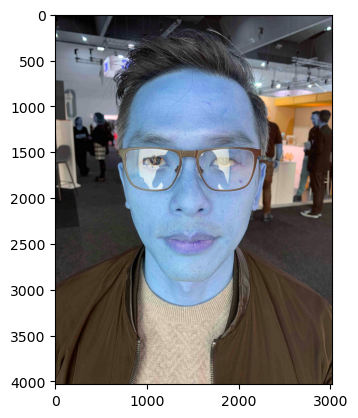

In [32]:
image_path = '/Users/danielfiuzadosil/Documents/GitHub_Repo/Data-Science/Tools/Image_Processing/gradio_app/v1/images/good/2.jpeg'
image = cv2.imread(image_path)
plt.imshow(image)

In [25]:
def img_to_string(img):
    # Encodes an image into a base64_string
    _, encoded_img = cv2.imencode('.PNG', img)
    base64_string = base64.b64encode(encoded_img).decode('utf-8')
    return base64_string

In [26]:
def string_to_img(base64_string):
    # Decodes a base64_string into an image
    imgdata = base64.b64decode(base64_string + '==')
    im = BytesIO(imgdata)
    img = mpimg.imread(im, format='PNG')
    opencv_img= cv2.cvtColor(np.array(img), cv2.COLOR_BGR2RGB)
    return opencv_img

In [27]:
def api_image_processing(image):
    # API Endpoint
    url = "http://13.42.31.235/fmc_api"
    # Step 1
    b64_string = img_to_string(image)
    #  Step 2
    payload ={"base64_string": b64_string}
    response = requests.post(url=url, data=payload) 
    base64_string_resp = response.json()['message']
    # Step 3
    img_output = string_to_img(base64_string_resp)
    # Return processed image
    return img_output

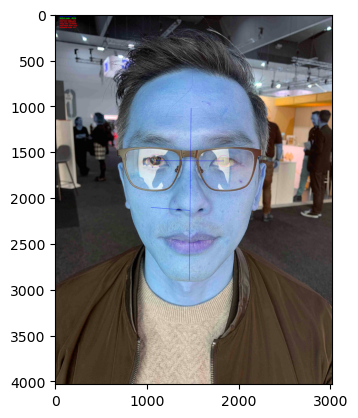

In [28]:
img_output = api_image_processing(image)
plt.imshow(img_output)

In [29]:
demo = gr.Interface(
    api_image_processing, 
    gr.Image(source="webcam", streaming=True), 
    "image",
    live=True
)

IMPORTANT: You are using gradio version 3.3.1, however version 3.14.0 is available, please upgrade.
--------


In [30]:
!pipreqs

In [31]:
demo.launch(share = True, debug=True)

Running on local URL:  http://127.0.0.1:7861
Running on public URL: https://0d3a22fc6614a0fe.gradio.app

This share link expires in 72 hours. For free permanent hosting, check out Spaces: https://www.huggingface.co/spaces


Keyboard interruption in main thread... closing server.


(<gradio.routes.App at 0x7fa651d14700>,
 'http://127.0.0.1:7861/',
 'https://0d3a22fc6614a0fe.gradio.app')